In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.integrate import solve_ivp

In [2]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [3]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(None, a, b) + noise
    return simulated

In [4]:
from scipy.integrate import odeint

# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10.0, 5.0]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(X, t, a, b, c, d):
    """Return the growth rate of fox and rabbit populations."""

    return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * b * X[0] * X[1]])


# simulator function
def competition_model(rng, a, b, size=None):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(a, b, c, d))

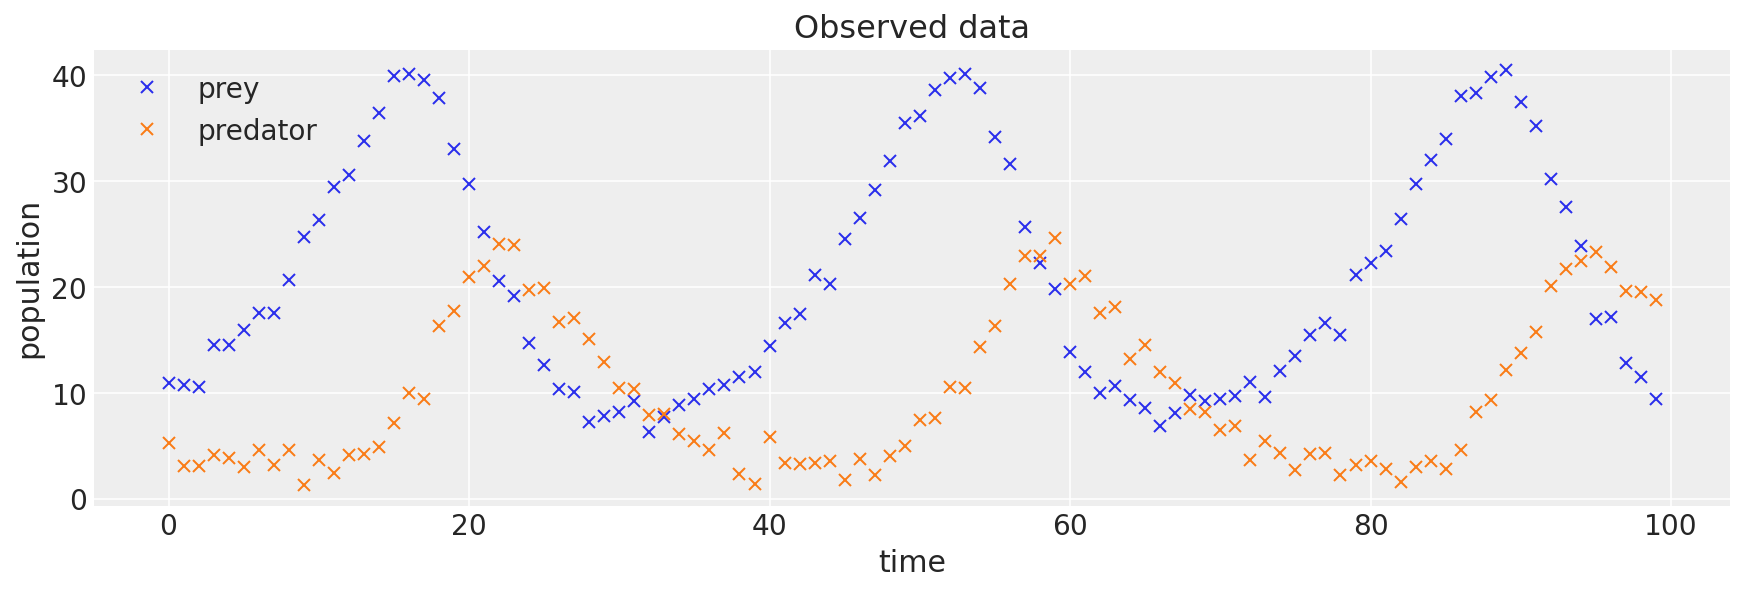

In [5]:
# plotting observed data.
observed = add_noise(a, b)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(observed[:, 0], "x", label="prey")
ax.plot(observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend()

In [ ]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.0)
    b = pm.HalfNormal("b", 1.0)

    sim = pm.Simulator("sim", competition_model, params=(a, b), epsilon=10, observed=observed)

    idata_lv = pm.sample_smc(cores=1)

Initializing SMC sampler...
Sampling 2 chains in 1 job


In [ ]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")
ax.plot(competition_model(None, posterior["a"].mean(), posterior["b"].mean()), linewidth=3)
for i in np.random.randint(0, size, 75):
    sim = competition_model(None, posterior["a"][i], posterior["b"][i])
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();